<a href="https://colab.research.google.com/github/TensorCruncher/PyTorch-Course-By-Daniel-Bourke/blob/main/04_PyTorch_Custom_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Custom Datasets

## 0. Importing PyTorch and setting up device-agnostic code

In [2]:
import torch
from torch import nn

torch.__version__

'2.4.0+cu121'

In [3]:
# Set up device agnositc code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

In [4]:
import requests
import zipfile
from pathlib import Path

# Set up path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download and prepare it
if image_path.is_dir():
  print(f"{image_path} directory exists")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


## 2. Become one with the data (data preparation)

In [5]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [7]:
# Set up train and test path
train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image

Random image path: data/pizza_steak_sushi/train/pizza/739735.jpg
Image class: pizza
Image height: 512
Image width: 384


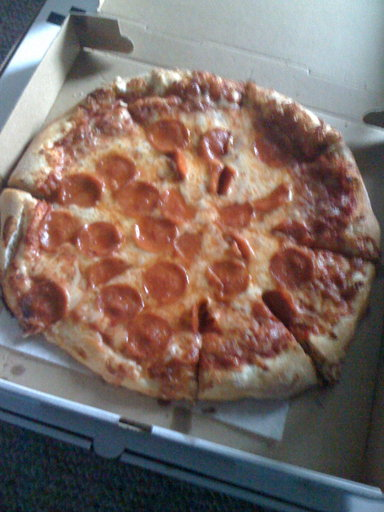

In [8]:
import random
from PIL import Image

# Set seed
random.seed(42)

# Get all image paths
image_path_list = list(train_dir.glob("*/*.jpg"))

# Get random image path
random_image_path = random.choice(image_path_list)

# Get image class from path name
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

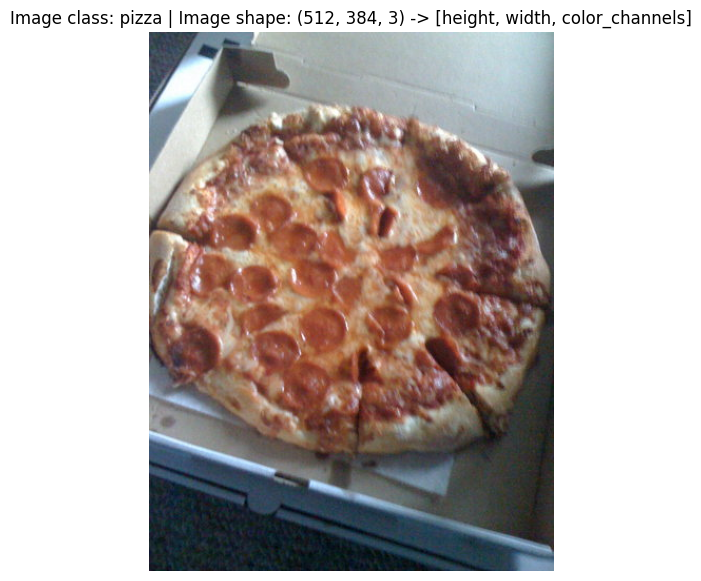

In [9]:
# Open image as numpy array
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into a numpy array
image_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(image_as_array)
plt.title(f"Image class: {image_class} | Image shape: {image_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## 3. Transforming data

In [10]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [11]:
# Write transform for image
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

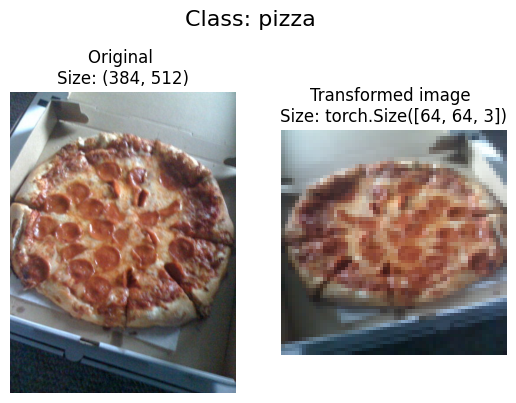

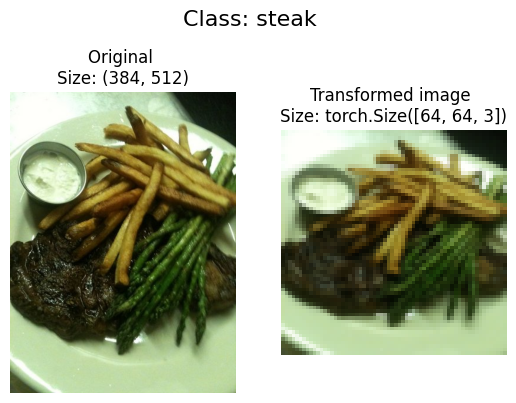

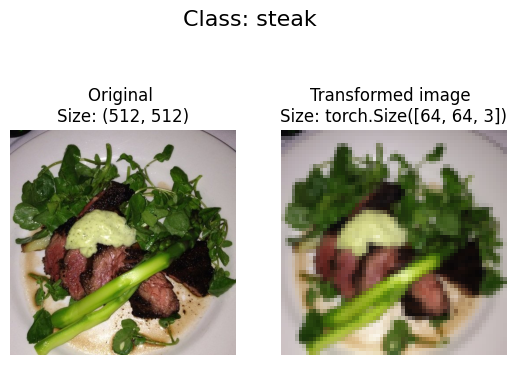

In [12]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1,2)

      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed image \nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
plot_transformed_images(image_path_list, data_transform, n=3)

## 4. Option 1: Loading Image Data Using `ImageFolder`

In [13]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [14]:
# Get class names as a list
class_names = train_data.classes
class_names


['pizza', 'steak', 'sushi']

In [15]:
# Get class names as dict, with idx
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Get length of train and test datasets
len(train_data), len(test_data)

(225, 75)

In [17]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


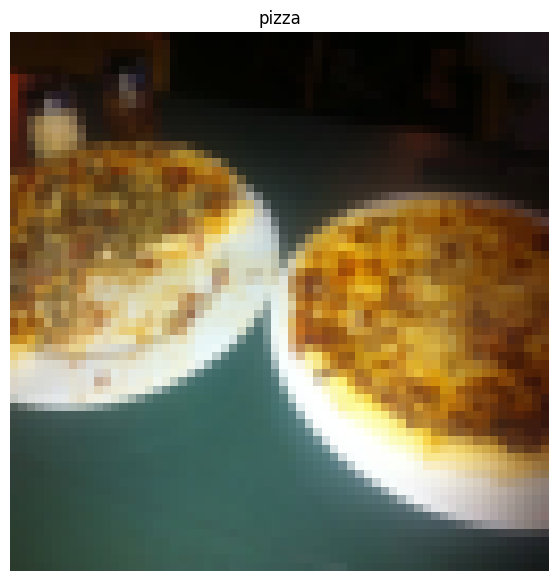

In [18]:
# Rearrange order of dimensions
img_permute = img.permute(1,2,0)

# Print shape before and after permute
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(f"{class_names[label]}");

### 4.1 Turn loaded images into DataLoader's

In [19]:
# Turn train and test Datasets into dataloaders

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=1,
    num_workers=1,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=1,
    num_workers=1,
    shuffle=False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fb19b029270>,
 <torch.utils.data.dataloader.DataLoader at 0x7fb19b1c28c0>)

In [20]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

In [21]:
import os
from pathlib import Path

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [22]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

In [23]:
# Set up path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get class names
class_names_found = sorted(entry.name for entry in list(os.scandir(image_path / "train")))
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [24]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}")

  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

  return classes, class_to_idx

In [25]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

In [26]:
# Write a custom Dataset class (inherits from torch.utils.data.Dataset)

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialise with targ_dir and transform (optional) parameter
  def __init__(self, targ_dir: str, transform = None) -> None:

    # 3. Create class attributes

    # Get all image paths
    self.paths = list(Path(targ_dir).glob("*/*.jpg"))

    # Setup transforms
    self.transform = transform

    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Make function to load images
  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__() method (optional but recommended)
  def __len__(self) -> int:
    return len(self.paths)

  # 6. Overwrite __getitem__() method (required)
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # Transform is necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx



In [27]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Reshape test data
test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [28]:
train_data_custom = ImageFolderCustom(train_dir, train_transforms)
test_data_custom = ImageFolderCustom(test_dir, test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7fb19b050160>,
 <__main__.ImageFolderCustom at 0x7fb19b051ed0>)

In [29]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [30]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [31]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [32]:
# Check for equality between custom Dataset and ImageFolder Dataset
print(len(train_data) == len(train_data_custom) and len(test_data) == len(test_data_custom))
print(train_data.classes == train_data_custom.classes)
print(train_data.class_to_idx == train_data_custom.class_to_idx)

True
True
True


### 5.3 Create a function to display random images

In [33]:
# Take in a Dataset and list of class names
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None
                          ):
  # Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"Value of n too high, setting to 10 and removing shape display")

  # Set random seed
  if seed:
    random.seed(seed)

  # Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # Setup plot
  plt.figure(figsize=(16,8))

  # Loop through random samples and display images
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # Adjust to color_channels last
    targ_image_adjust = targ_image.permute(1,2,0)

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nShape: {targ_image_adjust.shape}"
    plt.title(title)

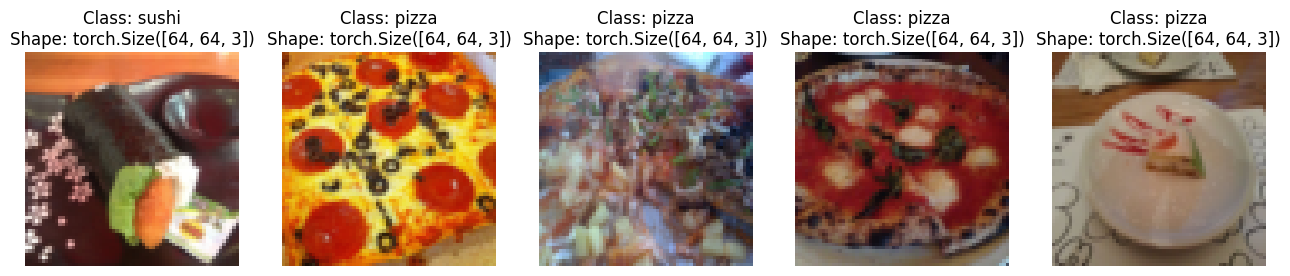

In [34]:
# Display random images from ImageFolder create Dataset
display_random_images(train_data, class_names, 5)

Value of n too high, setting to 10 and removing shape display


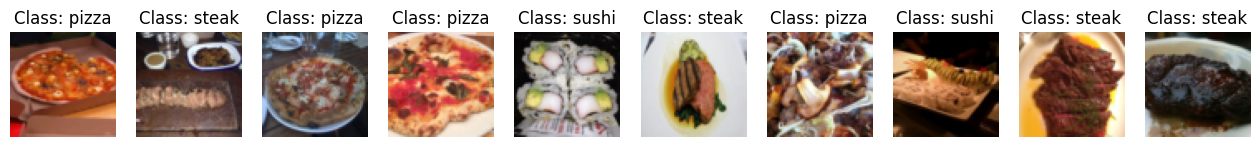

In [35]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom, class_names, 12)

### 5.4 Turn custom loaded images into `DataLoader`s

In [36]:
# Turn train and test custom Datasets into Dataloaders

train_dataloader_custom = DataLoader(
    dataset=train_data_custom,
    batch_size=1,
    num_workers=0,
    shuffle=True
)

test_dataloader_custom = DataLoader(
    dataset=test_data_custom,
    batch_size=1,
    num_workers=0,
    shuffle=False
)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7fb19ac32f20>,
 <torch.utils.data.dataloader.DataLoader at 0x7fb19add1bd0>)

In [37]:
# Get image and label from custom Dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Check shapes
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 6. Other forms of transforms (data augmentation)

In [38]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

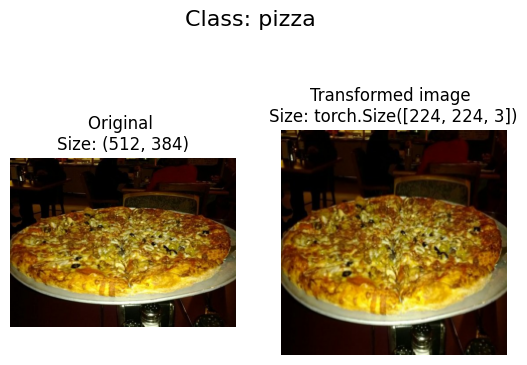

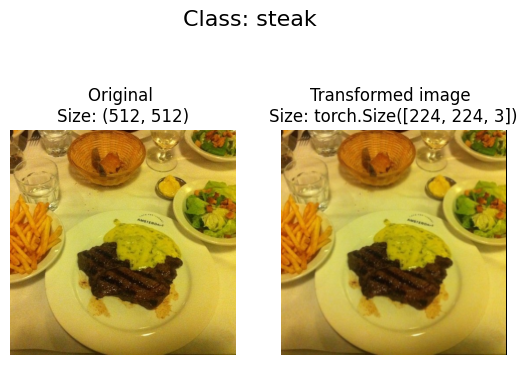

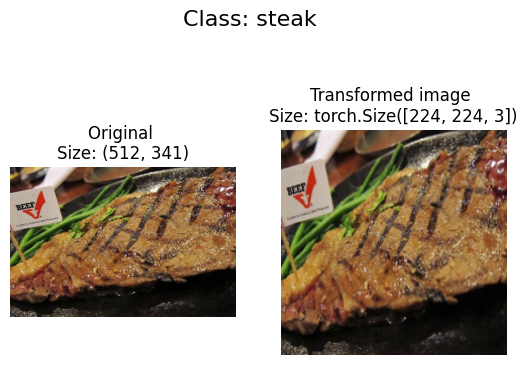

In [39]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(image_path_list, train_transforms, n=3)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for Model 0

In [40]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [41]:
# 1. Load and transform the data
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Setup batch size and number of workers
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

print(f"Creating dataloaders with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Creare dataloaders
train_dataloader_simple = DataLoader(dataset=train_data_simple, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

train_dataloader_simple, test_dataloader_simple


Creating dataloaders with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7fb19a84b760>,
 <torch.utils.data.dataloader.DataLoader at 0x7fb19a848ac0>)

### 7.2 Create TinyVGG model class

In [42]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

torch.manual_seed(42)

model_0 = TinyVGG(3, 10, len(train_data.classes)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [43]:
# 1. Get a batch of images and labels from the Dataloader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze it to match the shape required by the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass with a single image
model_0.eval()
with torch.inference_mode():
  pred = model_0(img_single.to(device))
# 4. Print out what's happening and convert logits -> probabilties -> label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0351]])

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]])

Output prediction label:
tensor([1])
Actual label:
2


### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [44]:
try:
  import torchinfo
except:
  print("Could not find torchinfo, installing...")
  !pip install torchinfo
  import torchinfo
from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

Could not find torchinfo, installing...


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 7.5 Create train & test loop functions

In [45]:
def train_step(model: torch.nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimiser: torch.optim.Optimizer):
  # Put model in train mode
  model.train()

  # Set up train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through batches in dataloader
  for batch, (X,y) in enumerate(train_dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X)

    # Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimiser zero grad
    optimiser.zero_grad()

    # Loss backward
    loss.backward()

    # Optimiser step
    optimiser.step()

    # Calculate and accumulate accuracy metrics accross all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(train_dataloader)
  train_acc = train_acc / len(train_dataloader)

  return train_loss, train_acc

In [46]:
def test_step(model: torch.nn.Module,
              test_dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  # Put model in eval mode
  model.eval()

  # Setup test loss and accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through batches in dataloader
    for batch, (X,y) in enumerate(test_dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # Forward pass
      test_pred_logits = model(X)

      # Calculate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(test_dataloader)
  test_acc = test_acc / len(test_dataloader)

  return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [47]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for train and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimiser: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  # 2. Create empty results dictionary
  results = {"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[]
             }

  # 3. Lopp through training and testing steps for number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimiser)
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn)

    # 4. Print out what's happening
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f}"
    )

    # 5. Update results dictionary
    # Ensure all data is moved to CPU and converted to float for storage (but we have not done that here, item extracts as float, but tensor has to be on CPU)
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  # 6. Return the filled results at the end of the total epochs
  return results

### 7.7 Train and Evaluate Model 0

In [58]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimiser=optimiser,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1166 | test_acc: 0.3002
Epoch: 2 | train_loss: 1.1197 | train_acc: 0.3164 | test_loss: 1.1194 | test_acc: 0.2775
Epoch: 3 | train_loss: 1.0950 | train_acc: 0.4141 | test_loss: 1.1048 | test_acc: 0.2576
Epoch: 4 | train_loss: 1.1113 | train_acc: 0.2930 | test_loss: 1.1030 | test_acc: 0.2775
Epoch: 5 | train_loss: 1.0955 | train_acc: 0.4141 | test_loss: 1.1051 | test_acc: 0.2576
Total training time: 11.170 seconds


### 7.8 Plot the loss curves of Model 0

In [59]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [60]:
def plot_loss_curves(results: Dict[str, List[float]]):

  # Get loss values from results dictionary (train and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get accuracy values from results dictionary (train and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out number of epochs
  epochs = range(len(results["train_loss"]))

  # Setup plot
  plt.figure(figsize=(15,7))

  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

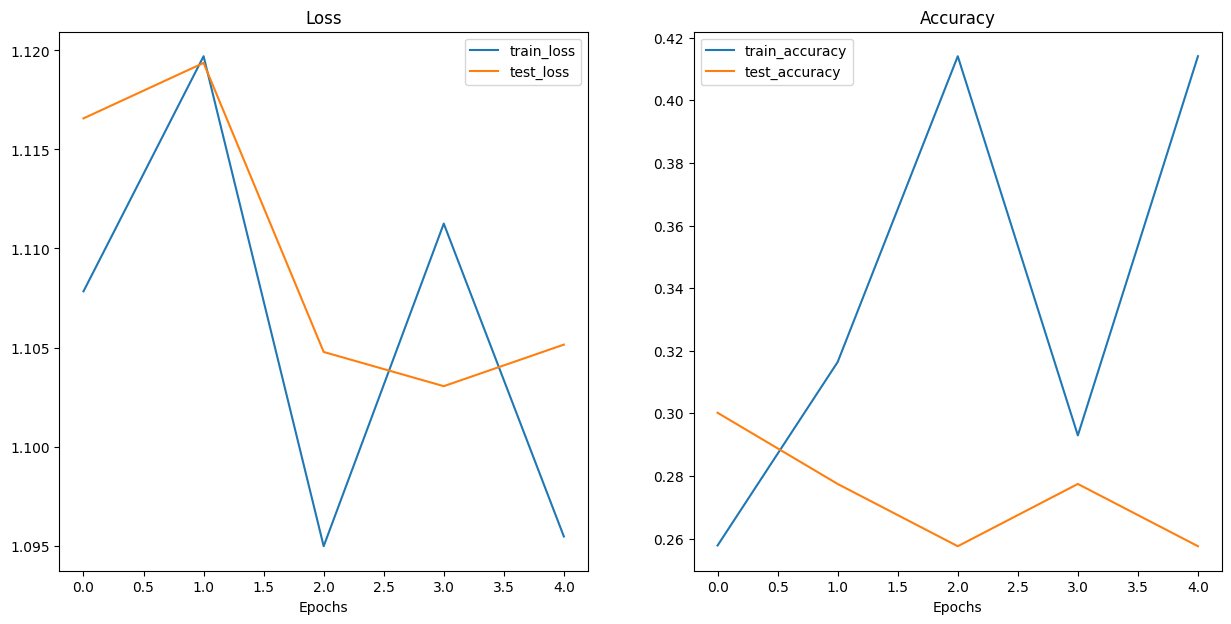

In [61]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

### 8.1 How to deal with overfitting

### 8.2 How to deal with underfitting

### 8.3 The balance between overfitting and underfitting

## 9. Model 1: TinyVGG with Data Augmentation

### 9.1 Create transform with data augmentation

In [62]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentaion)
test_transfrom = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset`s and `DataLoader`s

In [63]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, test_transfrom)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [64]:
# Turn Datasets into Dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(train_data_augmented, BATCH_SIZE, True, num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(test_data_simple, BATCH_SIZE, False, num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7fb19a8607c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fb19a860400>)

### 9.3 Construct and train Model 1

In [66]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(3,10,len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [70]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Set up loss function and optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start timer
start_time =timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimiser=optimiser,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End timer, print how long it took to train
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds.")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2500 | test_loss: 1.1062 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0791 | train_acc: 0.4258 | test_loss: 1.1387 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0810 | train_acc: 0.4258 | test_loss: 1.1696 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1292 | train_acc: 0.3047 | test_loss: 1.1625 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0899 | train_acc: 0.4258 | test_loss: 1.1482 | test_acc: 0.2604
Total training time: 12.468 seconds.


### 9.4 Plot the loss curves of Model 1

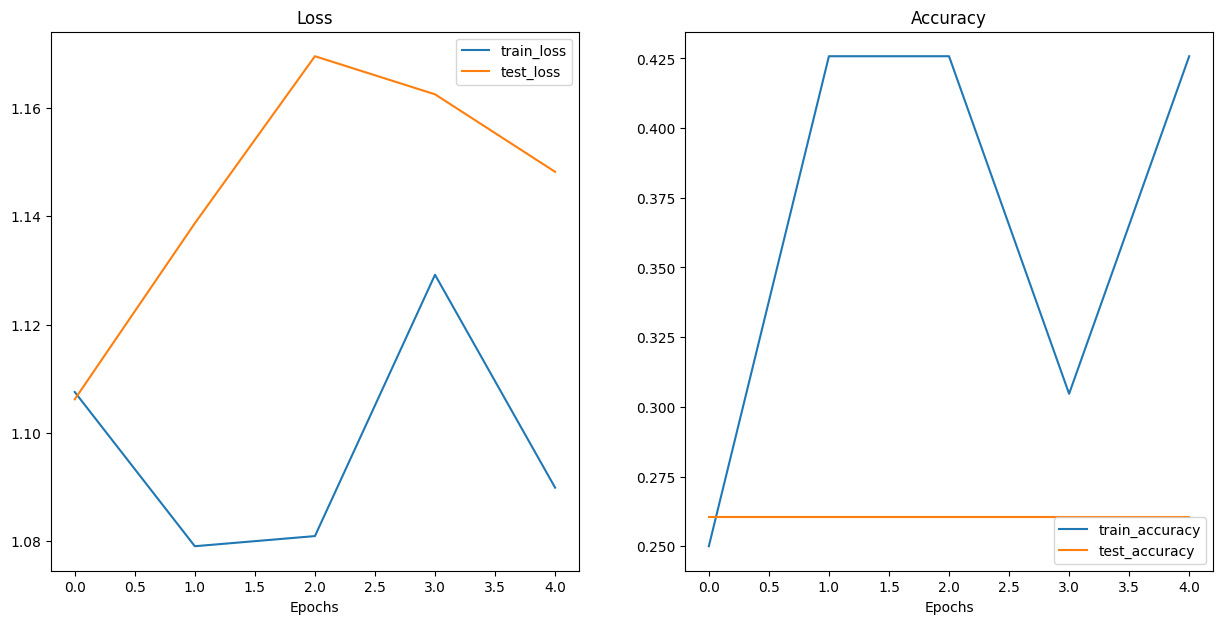

In [71]:
plot_loss_curves(model_1_results)

## 10. Compare model results

In [72]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

In [73]:
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107836,0.257812,1.116572,0.300189
1,1.119710,0.316406,1.119371,0.277462
2,1.094964,0.414062,1.104775,0.257576
3,1.111258,0.292969,1.103047,0.277462
4,1.095454,0.414062,1.105146,0.257576


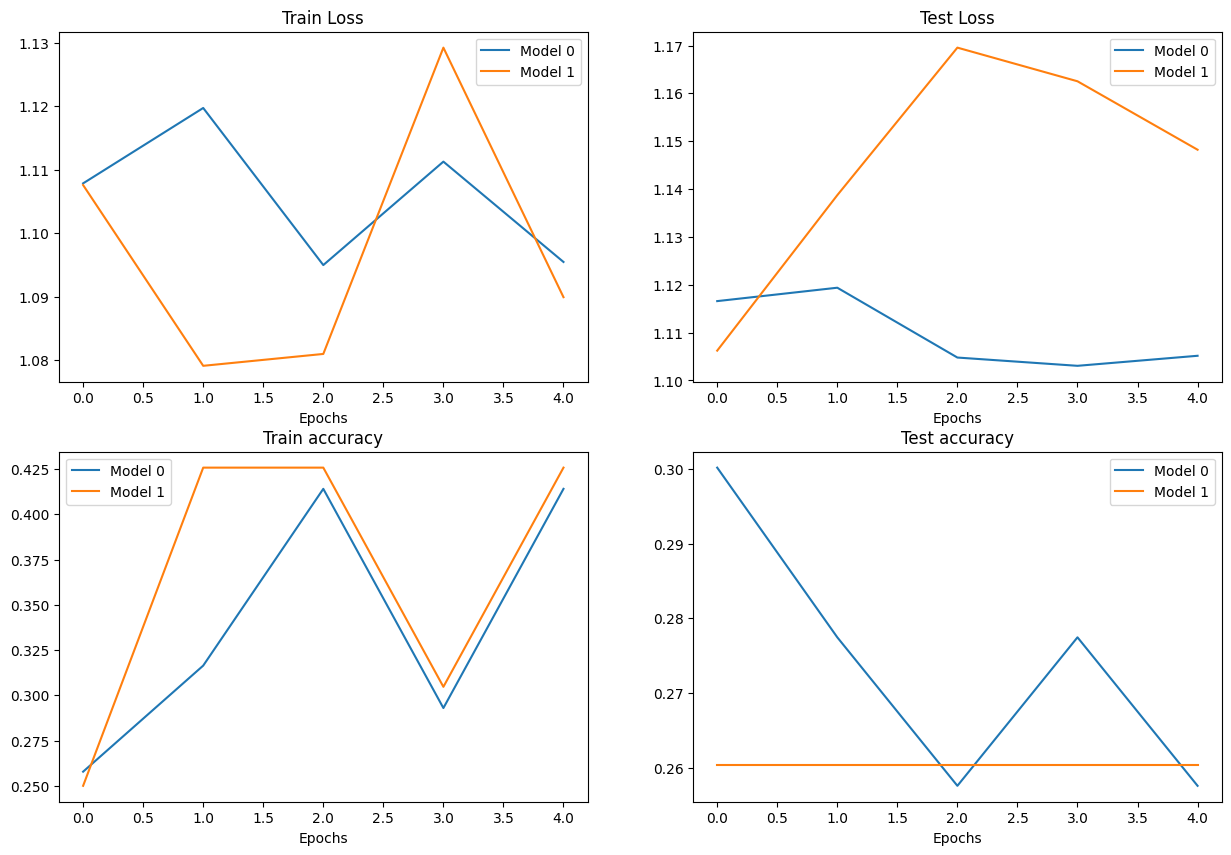

In [75]:
# Setup a plot
plt.figure(figsize=(15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test accuracy")
plt.xlabel("Epochs")
plt.legend();

## 11. Make a prediction on a custom image

In [76]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download.")

### 11.1 Loading in a custom image with PyTorch

In [80]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

In [81]:
# Load custom image and convert tensor values to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image /= 255

print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shaoe: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

### 11.2 Predicting on custom images with a trained PyTorch model

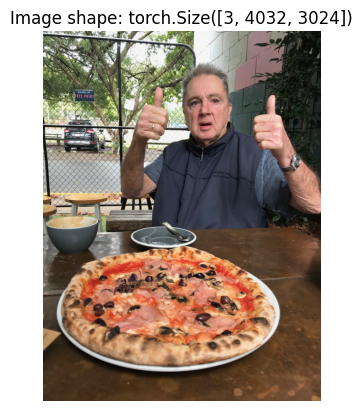

In [82]:
# Plot custom image
plt.imshow(custom_image.permute(1,2,0))
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [83]:
# Create transform pipeline to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64,64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [84]:
custom_image_transformed = custom_image_transformed.to(device)

In [86]:
model_1.eval()

with torch.inference_mode():
  # Add an extra dimension to image
  custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

  # Print out different shapes
  print(f"Custom image transformed shape: {custom_image_transformed.shape}")
  print(f"Unsqueezed custom image  shape: {custom_image_transformed_with_batch_size.shape}")

  # Make prediction on image with batch size
  custom_image_pred = model_1(custom_image_transformed_with_batch_size)

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image  shape: torch.Size([1, 3, 64, 64])


In [87]:
custom_image_pred

tensor([[ 0.1188,  0.0339, -0.1486]])

In [88]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits to prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities to prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.1188,  0.0339, -0.1486]])
Prediction probabilities: tensor([[0.3726, 0.3422, 0.2852]])
Prediction label: tensor([0])


In [89]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()]
custom_image_pred_class

'pizza'

### 11.3 Putting custom image prediction together: building a function

In [90]:
def pred_and_plot_image(model:torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform = None,
                        device: torch.device = device):
  # 1. Load in image and convert tensor values to float32
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # 2. Divide the image pixel values by 255 to get them in between [0, 1]
  target_image /= 255

  # 3. Transform if necessary
  if transform:
    target_image = transform(target_image)

  # 4. Make sure model is on target device
  model.to(device)

  # 5. Turn on model evaluation mode and inference mode
  model.eval()
  with torch.inference_mode():
    # Add extra dimension to image
    target_image = target_image.unsqueeze(dim=0)

    # Make prediction, send image to target device
    target_image_pred = model(target_image.to(device))

  # 6. Convert logits to prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # 7. Convert prediction probabilities to prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 8. Plot image, pred and pred prob
  plt.imshow(target_image.squeeze().permute(1,2,0))
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label.cpu()} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

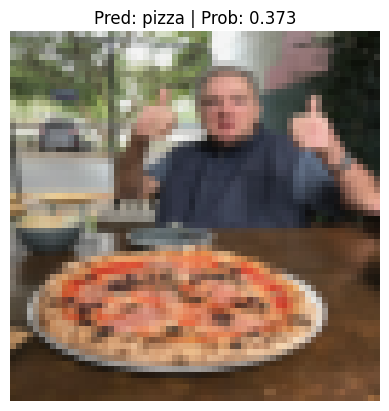

In [91]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)